In [1]:
import sys
from os.path import expanduser
from packages_and_style import *
from func_ECOG import *
get_ipython().magic('matplotlib inline')
matplotlib.rcParams['figure.figsize'] = (22, 5)

Using TensorFlow backend.


3.5.2 |Anaconda custom (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]
TF version: 1.0.1
Keras version: 2.0.2
 
##
[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16101272889954899995
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 3240778137
locality {
  bus_id: 1
}
incarnation: 12639140014564948368
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0"
]
##


In [2]:
filepath="models/loss-{val_loss:.20f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, period=1)
history = History()
earlystop=EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
callbacks_list = [history,earlystop,checkpoint]

In [3]:
data = pd.read_csv('RAW_data.csv',header=None)
data = np.array(data)

Raw_signals_all=scale(np.copy(data[:, 1:]))
Raw_signals_all = Raw_signals_all.astype(np.float32)

Y_all=np.copy(data[:, 0])
X_all=np.copy(data[:, 1:])

##########Y-filtration
Y_all=Y_filtration_and_scaling(Y_all)
X_all=X_filtration_and_scaling(X_all, filter_coef=False)
X_all = X_all.astype(np.float32)

#downsampling=2
#X_all=X_all[range(0,X_all.shape[0],downsampling),:]
#Y_all=Y_all[range(0,Y_all.shape[0],downsampling)]

In [4]:
window_wc=150
window_size=window_wc

In [5]:

X_all=np.atleast_3d(np.array([np.transpose(X_all[start:start + window_size]) for start in range(0, X_all.shape[0] - window_size)]))
Raw_signals_all=np.atleast_3d(np.array([np.transpose(Raw_signals_all[start:start + window_size]) for start in range(0, Raw_signals_all.shape[0] - window_size)]))

Y_all=Y_all[window_size:]



ntr=int(len(Y_all)*0.5)
val=int(len(Y_all)*0.75)


Y = np.copy(Y_all[:ntr])
X = np.copy(X_all[:ntr, :])
Raw_signals= np.copy(Raw_signals_all[:ntr, :])

Y_val=np.copy(Y_all[ntr:val])
Y_test=np.copy(Y_all[val:])
Y_val_and_test=np.copy(Y_all[ntr:])

X_val=np.copy(X_all[ntr:val, :])
Raw_signals_val=np.copy(Raw_signals_all[ntr:val, :])

In [6]:
inputs=[X[:,0:20,:],X[:,20:40,:],X[:,40:60,:],X[:,60:80,:]]
inputs_val=[X_val[:,0:20,:],X_val[:,20:40,:],X_val[:,40:60,:],X_val[:,60:80,:]]
inputs_all=[X_all[:,0:20,:],X_all[:,20:40,:],X_all[:,40:60,:],X_all[:,60:80,:]]

In [7]:
inputs_r=[Raw_signals[:,0,:],Raw_signals[:,1,:],Raw_signals[:,2,:],Raw_signals[:,3,:]]
inputs_r_val=[Raw_signals_val[:,0,:],Raw_signals_val[:,1,:],Raw_signals_val[:,2,:],Raw_signals_val[:,3,:]]
inputs_r_all=[Raw_signals_all[:,0,:],Raw_signals_all[:,1,:],Raw_signals_all[:,2,:],Raw_signals_all[:,3,:]]

In [8]:
inputs_full=inputs+inputs_r
inputs_full_val=inputs_val+inputs_r_val
inputs_full_all=inputs_all+inputs_r_all

Train on 56925 samples, validate on 28462 samples
Epoch 1/10
56925/56925 [==============================] - 34s - loss: 1.1073 - val_loss: 0.3637
Epoch 2/10
56925/56925 [==============================] - 30s - loss: 0.4291 - val_loss: 0.3538
Epoch 3/10
56925/56925 [==============================] - 27s - loss: 0.3240 - val_loss: 0.3030
Epoch 4/10
56925/56925 [==============================] - 29s - loss: 0.2836 - val_loss: 0.2825
Epoch 5/10
56925/56925 [==============================] - 30s - loss: 0.2627 - val_loss: 0.2808
Epoch 6/10
56925/56925 [==============================] - 30s - loss: 0.2475 - val_loss: 0.2856
Epoch 7/10
56925/56925 [==============================] - 29s - loss: 0.2395 - val_loss: 0.2774
Epoch 8/10
56925/56925 [==============================] - 31s - loss: 0.2335 - val_loss: 0.2826
Epoch 9/10
56925/56925 [==============================] - 30s - loss: 0.2282 - val_loss: 0.2765
Epoch 10/10
56925/56925 [==============================] - 30s - loss: 0.2250 - val_lo

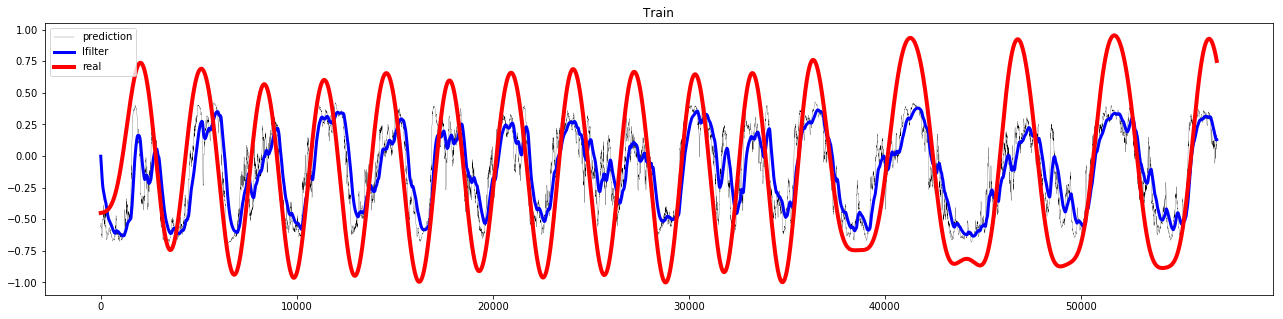

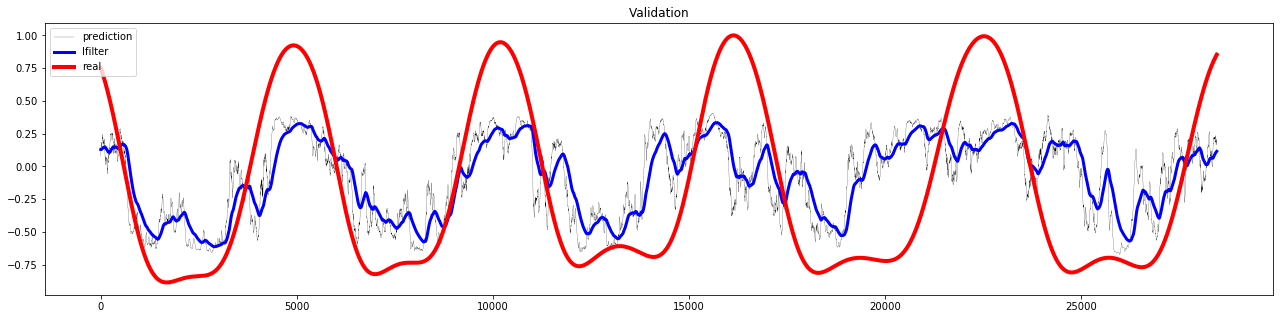

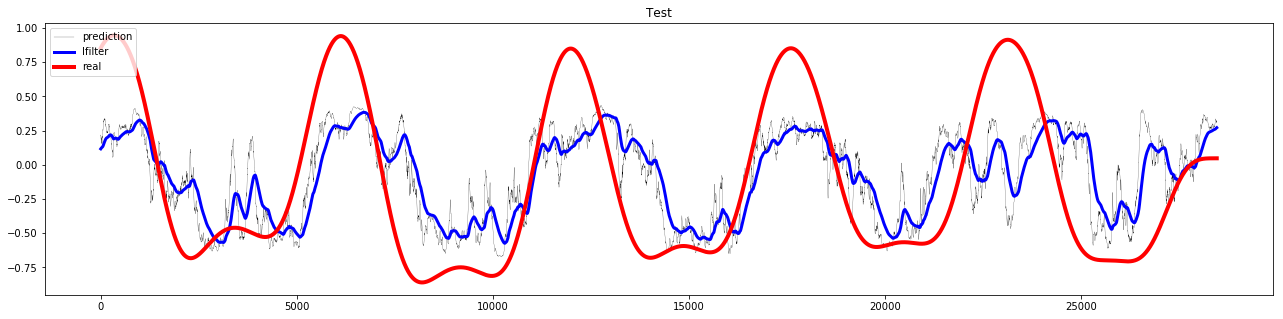

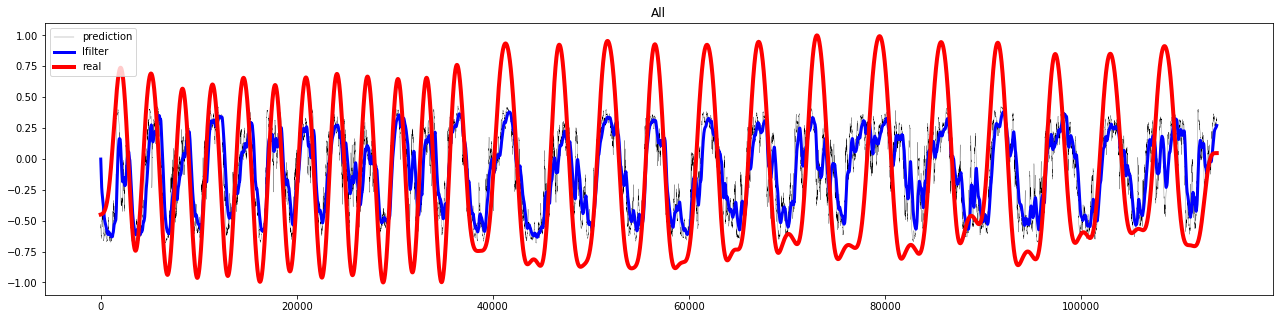

In [10]:
filters=n_filter_wc_hidden_1=1
mdl_NN=None
###############
epoch=10
b_size=40
learn_r=0.0003

LC=LocallyConnected2D(filters=n_filter_wc_hidden_1, kernel_size=(1,window_wc),data_format='channels_first',use_bias=False)

inp={}
inp_r={}
x_all={}

for i in range(len(inputs)):
    inp["inputs{0}".format(i)]=Input(shape=(int(inputs[i].shape[1]),window_size), name ='inputs'+str(i))
    x_all["x{0}".format(i)]=Reshape((1, int(inputs[i].shape[1]),window_size))(inp['inputs'+str(i)])
    #x_all["x{0}".format(i)]=Conv2D(20, kernel_size=(1,window_wc), data_format='channels_first',use_bias=False)(x_all['x'+str(i)])
    x_all["x{0}".format(i)]=LC(x_all['x'+str(i)])
    x_all["x{0}".format(i)]=Flatten()(x_all['x'+str(i)])
    x_all["x{0}".format(i)]=Dense(8)(x_all['x'+str(i)])
    x_all["x{0}".format(i)]=BatchNormalization()(x_all['x'+str(i)])
    x_all["x{0}".format(i)]=Activation('tanh')(x_all['x'+str(i)])
    x_all["x{0}".format(i)]=Dropout(0.7)(x_all['x'+str(i)])

    
for i in range(len(inputs_r)):
    inp_r["inputs_r{0}".format(i)]=Input(shape=(window_size,), name ='inputs_r'+str(i))
    x_all["x_r{0}".format(i)]=Reshape((1, 1, window_size))(inp_r['inputs_r'+str(i)])
    x_all["x_r{0}".format(i)]=Conv2D(20, kernel_size=(1,window_wc), data_format='channels_first')(x_all['x_r'+str(i)])
    x_all["x_r{0}".format(i)]=Flatten()(x_all['x_r'+str(i)])
    x_all["x_r{0}".format(i)]=Dense(8)(x_all['x_r'+str(i)])
    x_all["x_r{0}".format(i)]=BatchNormalization()(x_all['x_r'+str(i)])
    x_all["x_r{0}".format(i)]=Activation('tanh')(x_all['x_r'+str(i)])
    x_all["x_r{0}".format(i)]=Dropout(0.7)(x_all['x_r'+str(i)])
    

x = keras.layers.concatenate(list(x_all.values()))


x = Dense(12,input_dim=X.shape[1])(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x=Dropout(0.7)(x)

predictions = Dense(1)(x)

mdl_NN = Model(inputs=list(inp.values())+list(inp_r.values()), outputs=predictions)
mdl_NN.compile(optimizer=Adam(lr=learn_r, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
               loss='mse')

########################
#mdl_NN.summary()



mdl_NN.fit(inputs_full, Y, validation_data=(inputs_full_val,Y_val),verbose=1, epochs=epoch, batch_size=b_size)
Y_predicted_all=np.copy(mdl_NN.predict(inputs_full_all, batch_size=b_size))
Y_predicted_all=np.copy((Y_predicted_all)[:,0])


Y_predicted_train=np.copy(Y_predicted_all[:ntr])
Y_predicted_val=np.copy(Y_predicted_all[ntr:val])
Y_predicted_test=np.copy(Y_predicted_all[val:])
Y_predicted_val_and_test=np.copy(Y_predicted_all[ntr:])


results_show(Y_all, Y, Y_val, Y_test, Y_val_and_test, 
        Y_predicted_all, Y_predicted_train, Y_predicted_val, Y_predicted_test, Y_predicted_val_and_test,
        ntr,val, "NN")




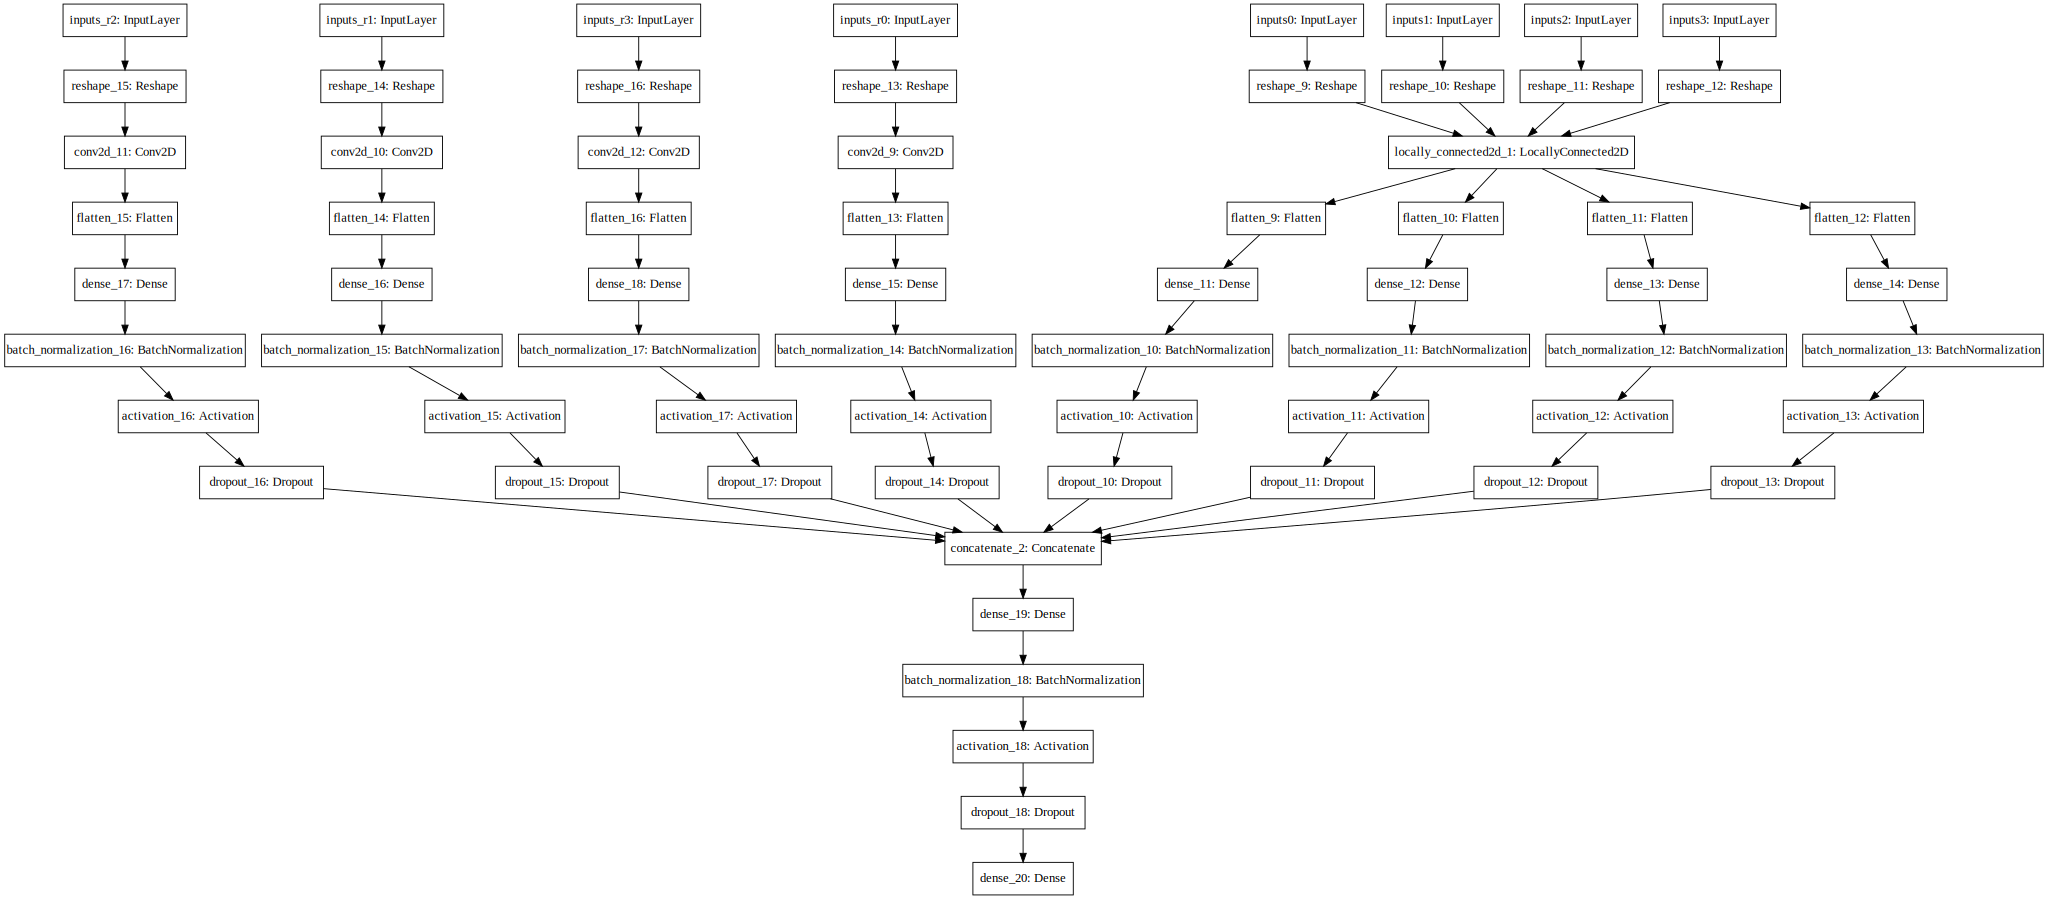

In [11]:
SVG(model_to_dot(mdl_NN).create(prog='dot', format='svg'))